# 第5章: 係り受け解析
    
time required: 
 
---

夏目漱石の小説『吾輩は猫である』の文章（neko.txt）をCaboChaを使って係り受け解析し，その結果をneko.txt.cabochaというファイルに保存せよ．このファイルを用いて，以下の問に対応するプログラムを実装せよ．

In [1]:
%%bash

# download
if [ ! -f neko.txt ]; then
    wget http://www.cl.ecei.tohoku.ac.jp/nlp100/data/neko.txt
fi

# call cabocha
if [ ! -f neko.txt.cabocha ]; then
    sed 's/^　//' neko.txt > neko_noindent.txt
    cabocha -f 1 neko_noindent.txt > neko.txt.cabocha
fi

head -20 neko.txt.cabocha

* 0 -1D 0/0 0.000000
一	名詞,数,*,*,*,*,一,イチ,イチ
EOS
EOS
* 0 1D 0/1 0.000000
吾輩	名詞,代名詞,一般,*,*,*,吾輩,ワガハイ,ワガハイ
は	助詞,係助詞,*,*,*,*,は,ハ,ワ
* 1 -1D 0/2 0.000000
猫	名詞,一般,*,*,*,*,猫,ネコ,ネコ
で	助動詞,*,*,*,特殊・ダ,連用形,だ,デ,デ
ある	助動詞,*,*,*,五段・ラ行アル,基本形,ある,アル,アル
。	記号,句点,*,*,*,*,。,。,。
EOS
* 0 2D 0/1 -1.911675
名前	名詞,一般,*,*,*,*,名前,ナマエ,ナマエ
は	助詞,係助詞,*,*,*,*,は,ハ,ワ
* 1 2D 0/0 -1.911675
まだ	副詞,助詞類接続,*,*,*,*,まだ,マダ,マダ
* 2 -1D 0/0 0.000000
無い	形容詞,自立,*,*,形容詞・アウオ段,基本形,無い,ナイ,ナイ


## 40. 係り受け解析結果の読み込み（形態素）

形態素を表すクラスMorphを実装せよ．このクラスは表層形（surface），基本形（base），品詞（pos），品詞細分類1（pos1）をメンバ変数に持つこととする．さらに，CaboChaの解析結果（neko.txt.cabocha）を読み込み，各文をMorphオブジェクトのリストとして表現し，3文目の形態素列を表示せよ．

In [2]:
class Morph(object):
    def __init__(self, surface, base, pos, pos1):
        self.surface = surface
        self.base = base
        self.pos = pos
        self.pos1 = pos1
        
    def __repr__(self):
        return '<Morpheme: %s (%s): %s %s>' % (self.surface, self.base, self.pos, self.pos1)
    
    #def __str__(self):
    #    return self.surface
    
    @staticmethod
    def construct(line):
        surface = line.split('\t', 1)
        elem = surface[-1].split(',')
        assert len(elem) > 5, elem
        return Morph(surface[0], elem[6], elem[0], elem[1])


In [3]:
# read mecab output file

doc = []
with open('neko.txt.cabocha', 'r', encoding='utf8') as f:
    for s in f.read().split('EOS\n'):
        sent = []
        for line in s.strip().split('\n'):
            if '\t' in line:
                sent.append(Morph.construct(line))
        if sent:
            doc.append(sent)

doc[2]

[<Morpheme: 名前 (名前): 名詞 一般>,
 <Morpheme: は (は): 助詞 係助詞>,
 <Morpheme: まだ (まだ): 副詞 助詞類接続>,
 <Morpheme: 無い (無い): 形容詞 自立>,
 <Morpheme: 。 (。): 記号 句点>]

## 41. 係り受け解析結果の読み込み（文節・係り受け）

40に加えて，文節を表すクラスChunkを実装せよ．このクラスは形態素（Morphオブジェクト）のリスト（morphs），係り先文節インデックス番号（dst），係り元文節インデックス番号のリスト（srcs）をメンバ変数に持つこととする．さらに，入力テキストのCaboChaの解析結果を読み込み，１文をChunkオブジェクトのリストとして表現し，8文目の文節の文字列と係り先を表示せよ．第5章の残りの問題では，ここで作ったプログラムを活用せよ．

In [4]:
class Chunk():
    def __init__(self, morphs, dst, srcs):
        self.morphs = morphs # list of Morphs
        self.dst = dst         # int         (parent)
        self.srcs = srcs       # list of int (children)
        
    def __repr__(self):
        surface = ' '.join([m.surface for m in self.morphs])
        return '<Chunk: %s (%d)>' % (surface, self.dst)
    
    def surface(self, sep=' '):
        return sep.join([m.surface for m in self.morphs if m.pos != u'記号'])
    
    @staticmethod
    def construct(chunk, raw):
        info = chunk.strip().split('\n', 1)
        idx = info[0].strip().split()
        dst = int(idx[2][:-1])
        m = re.findall(r'\** \d{1,3} '+idx[1]+'D', raw)
        srcs = [int(i.split()[1]) for i in m]
        morphs = []
        for line in info[1].strip().split('\n'):
            morphs.append(Morph.construct(line))
        return Chunk(morphs, dst, srcs)

In [5]:
import re
# read cabocha output file

dependency = []
with open('neko.txt.cabocha', 'r', encoding='utf8') as f:
    for sent in f.read().split('EOS\n'):
        graph = []
        for chunk in sent.strip().split('\n*'):
            if chunk:
                graph.append(Chunk.construct('*'+chunk, sent))
        dependency.append(graph)

dependency[7]

[<Chunk: 吾輩 は (5)>,
 <Chunk: ここ で (2)>,
 <Chunk: 始め て (3)>,
 <Chunk: 人間 という (4)>,
 <Chunk: もの を (5)>,
 <Chunk: 見 た 。 (-1)>]

## 42. 係り元と係り先の文節の表示

係り元の文節と係り先の文節のテキストをタブ区切り形式ですべて抽出せよ．ただし，句読点などの記号は出力しないようにせよ．

In [6]:
sent = dependency[7]
for dep in sent:
    head = sent[dep.dst] if dep.dst > -1 else None
    dependents = [sent[i] for i in dep.srcs]
    print(dep)
    print('\thead: %r' % (head.surface() if head else 'ROOT'))
    print('\tdeps: %s\n' % '\t'.join([repr(d.surface()) for d in dependents]))

<Chunk: 吾輩 は (5)>
	head: '見 た'
	deps: 

<Chunk: ここ で (2)>
	head: '始め て'
	deps: 

<Chunk: 始め て (3)>
	head: '人間 という'
	deps: 'ここ で'

<Chunk: 人間 という (4)>
	head: 'もの を'
	deps: '始め て'

<Chunk: もの を (5)>
	head: '見 た'
	deps: '人間 という'

<Chunk: 見 た 。 (-1)>
	head: 'ROOT'
	deps: '吾輩 は'	'もの を'



## 43. 名詞を含む文節が動詞を含む文節に係るものを抽出

名詞を含む文節が，動詞を含む文節に係るとき，これらをタブ区切り形式で抽出せよ．ただし，句読点などの記号は出力しないようにせよ．

In [8]:
for sent in dependency[:10]: # first 10 sentences only
    for dep in sent:
        if dep.dst > -1 and u'名詞' in [m.pos for m in dep.morphs]:
                head = sent[dep.dst]
                if u'動詞' in [m.pos for m in head.morphs]:
                    print('%s\t%s' % (dep.surface(), head.surface()))

どこ で	生れ た か
見当 が	つか ぬ
所 で	泣い て
ニャーニャー	泣い て
いた事 だけ は	記憶 し て いる
吾輩 は	見 た
ここ で	始め て
もの を	見 た
あと で	聞く と
我々 を	捕え て


## 44. 係り受け木の可視化

与えられた文の係り受け木を有向グラフとして可視化せよ．可視化には，係り受け木をDOT言語に変換し，Graphvizを用いるとよい．また，Pythonから有向グラフを直接的に可視化するには，pydotを使うとよい．

In [9]:
import pydot

def build_graph(sent):
    g = pydot.Dot(graph_type="digraph")

    # nodes
    for i, chunk in enumerate(sent):
        g.add_node(pydot.Node(str(i), label=chunk.surface()))

    # edges
    for i, chunk in enumerate(sent):
        if chunk.dst > -1:
            g.add_edge(pydot.Edge(str(i), str(chunk.dst)))
    
    return g.to_string()


In [10]:
from IPython.display import SVG, display
import subprocess

# source: http://www.nltk.org/_modules/nltk/parse/dependencygraph.html

def display_graph(dot_string):
    process = subprocess.Popen(
        ['dot', '-Tsvg'],
        stdin=subprocess.PIPE,
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
        universal_newlines=True,
    )
    out, err = process.communicate(dot_string)
    display(SVG(out))
    

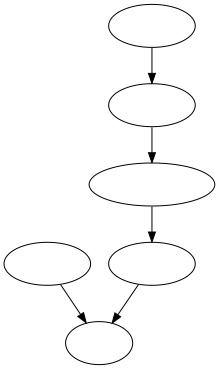

In [11]:
sent = dependency[7]
dependency_graph = build_graph(sent)
display_graph(dependency_graph)

## 45. 動詞の格パターンの抽出

今回用いている文章をコーパスと見なし，日本語の述語が取りうる格を調査したい． 動詞を述語，動詞に係っている文節の助詞を格と考え，述語と格をタブ区切り形式で出力せよ． ただし，出力は以下の仕様を満たすようにせよ．

- 動詞を含む文節において，最左の動詞の基本形を述語とする
- 述語に係る助詞を格とする
- 述語に係る助詞（文節）が複数あるときは，すべての助詞をスペース区切りで辞書順に並べる

「吾輩はここで始めて人間というものを見た」という例文（neko.txt.cabochaの8文目）を考える． この文は「始める」と「見る」の２つの動詞を含み，「始める」に係る文節は「ここで」，「見る」に係る文節は「吾輩は」と「ものを」と解析された場合は，次のような出力になるはずである．

```
始める    で
見る    は を
````

このプログラムの出力をファイルに保存し，以下の事項をUNIXコマンドを用いて確認せよ．

- コーパス中で頻出する述語と格パターンの組み合わせ
- 「する」「見る」「与える」という動詞の格パターン（コーパス中で出現頻度の高い順に並べよ）

In [12]:
from collections import defaultdict

freq = defaultdict(list)
with open('case_patterns.txt', 'w', encoding='utf8') as f:
    for sent in dependency:
        for dep in sent:
            if u'動詞' in [m.pos for m in dep.morphs]:
                predicate = [m for m in dep.morphs if m.pos==u'動詞'][0].base
                cases = []
                for dependent in [sent[i] for i in dep.srcs]:
                    case = [m for m in dependent.morphs if m.pos==u'助詞']
                    if case:
                        cases.append(case[0].base)
                f.write('%s\t%s\n' % (predicate, ' '.join(sorted(cases))))

In [13]:
%%bash

cat case_patterns.txt | sort | uniq -c | sort -nr | head -20

 584 云う	と
 443 する	を
 435 する	
 256 思う	と
 207 なる	に
 199 ある	が
 188 する	に
 179 見る	て
 134 する	と
 122 云う	
 117 する	が
 110 する	に を
 108 なる	
 102 する	て を
  94 見る	を
  94 ある	
  93 見える	と
  89 いる	
  88 する	て
  80 見る	


In [14]:
%%bash

grep -E "^する" case_patterns.txt | sort | uniq -c | sort -nr | head -20

 443 する	を
 435 する	
 188 する	に
 134 する	と
 117 する	が
 110 する	に を
 102 する	て を
  88 する	て
  61 する	は
  60 する	が を
  51 する	で を
  50 する	から
  43 する	で
  42 する	と を
  42 する	の
  39 する	も
  38 する	から を
  31 する	が に
  29 する	と は
  28 する	は を


In [15]:
%%bash

grep -E "^見る" case_patterns.txt | sort | uniq -c | sort -nr | head -20

 179 見る	て
  94 見る	を
  80 見る	
  25 見る	て て
  20 見る	から
  16 見る	て を
  15 見る	と
  13 見る	で
  12 見る	から て
  10 見る	て は
   9 見る	に
   8 見る	に を
   7 見る	が を
   7 見る	が
   6 見る	て は を
   5 見る	で を
   5 見る	て ば
   5 見る	て と
   5 見る	は
   4 見る	から を


In [16]:
%%bash

grep -E "^与える" case_patterns.txt | sort | uniq -c | sort -nr | head -20

   3 与える	に を
   2 与える	て に は を
   1 与える	けれども に を
   1 与える	じゃあ て は を
   1 与える	として を
   1 与える	だけ で を
   1 与える	たり に を
   1 与える	に に対して も
   1 与える	て て と に は は を
   1 与える	て に に は を
   1 与える	て に を
   1 与える	ば を
   1 与える	て を
   1 与える	け に
   1 与える	が を


## 46. 動詞の格フレーム情報の抽出

45のプログラムを改変し，述語と格パターンに続けて項（述語に係っている文節そのもの）をタブ区切り形式で出力せよ．45の仕様に加えて，以下の仕様を満たすようにせよ．

- 項は述語に係っている文節の単語列とする（末尾の助詞を取り除く必要はない）
- 述語に係る文節が複数あるときは，助詞と同一の基準・順序でスペース区切りで並べる

「吾輩はここで始めて人間というものを見た」という例文（neko.txt.cabochaの8文目）を考える． この文は「始める」と「見る」の２つの動詞を含み，「始める」に係る文節は「ここで」，「見る」に係る文節は「吾輩は」と「ものを」と解析された場合は，次のような出力になるはずである．

```
始める  で      ここで
見る    は を   吾輩は ものを
```

In [17]:
freq = defaultdict(list)
with open('case_frames.txt', 'w', encoding='utf8') as f:
    for sent in dependency:
        for dep in sent:
            if u'動詞' in [m.pos for m in dep.morphs]:
                predicate = [m for m in dep.morphs if m.pos==u'動詞'][0].base
                particles = []
                chunks = []
                for dependent in [sent[i] for i in dep.srcs]:
                    particle = [m for m in dependent.morphs if m.pos==u'助詞']
                    if particle:
                        particles.append(particle[0].base)
                        chunks.append(dependent.surface(sep=''))
                string = '%s\t%s' % (predicate, ' '.join(sorted(particles)))
                string += '\t%s' % (' '.join([c for p, c in sorted(zip(particles, chunks), key=lambda x: x[0])]))
                f.write(string + '\n')

In [18]:
%%bash

head -20 case_frames.txt

生れる	で	どこで
つく	か が	生れたか 見当が
する		
泣く	で	所で
する	だけ て	いた事だけは 泣いて
始める	で	ここで
見る	は を	吾輩は ものを
聞く	で	あとで
捕える	を	我々を
煮る	て	捕えて
食う	て	煮て
思う	から	なかったから
載せる	に	掌に
持ち上げる	て と	載せられて スーと
する		
ある	が	感じが
落ちつく	で	上で
見る	て を	落ちついて 顔を
見る	の	ものの
思う	と	ものだと


## 47. 機能動詞構文のマイニング

動詞のヲ格にサ変接続名詞が入っている場合のみに着目したい．46のプログラムを以下の仕様を満たすように改変せよ．

- 「サ変接続名詞+を（助詞）」で構成される文節が動詞に係る場合のみを対象とする
- 述語は「サ変接続名詞+を+動詞の基本形」とし，文節中に複数の動詞があるときは，最左の動詞を用いる
- 述語に係る助詞（文節）が複数あるときは，すべての助詞をスペース区切りで辞書順に並べる
- 述語に係る文節が複数ある場合は，すべての項をスペース区切りで並べる（助詞の並び順と揃えよ）

例えば「別段くるにも及ばんさと、主人は手紙に返事をする。」という文から，以下の出力が得られるはずである．

```
返事をする      と に は        及ばんさと 手紙に 主人は
```

このプログラムの出力をファイルに保存し，以下の事項をUNIXコマンドを用いて確認せよ．

- コーパス中で頻出する述語（サ変接続名詞+を+動詞）
- コーパス中で頻出する述語と助詞パターン

In [19]:
freq = defaultdict(list)
with open('verb_frames.txt', 'w', encoding='utf8') as f:
    for sent in dependency:
        for j, dep in enumerate(sent):
            if j > 0 and u'動詞' in [m.pos for m in dep.morphs]:
                prev = sent[j-1]
                wo = prev.morphs[-1].surface
                if prev.morphs[-1].surface == u'を' and prev.morphs[-2].pos1 == u'サ変接続':
                    predicate = prev.morphs[-2].surface + prev.morphs[-1].surface
                    predicate += [m.base for m in dep.morphs if m.pos == u'動詞'][0]
                
                    particles = []
                    chunks = []
                    for i in dep.srcs:
                        dependent = sent[i]
                        particle = [m for m in dependent.morphs if m.pos==u'助詞']
                        if particle:
                            particles.append(particle[0].base)
                            chunks.append(dependent.surface(sep=''))
                    string = '%s\t%s' % (predicate, ' '.join(sorted(particles)))
                    string += '\t%s' % (' '.join([c for p, c in sorted(zip(particles, chunks), key=lambda x: x[0])]))
                    f.write(string + '\n')

In [20]:
%%bash

cut -f1 verb_frames.txt | sort | uniq -c | sort -nr | head -20

  30 返事をする
  21 挨拶をする
  16 話をする
  14 真似をする
  13 喧嘩をする
   8 質問をする
   7 運動をする
   6 昼寝をする
   5 質問をかける
   5 相談をする
   5 病気をする
   5 注意をする
   5 話を聞く
   4 いたずらをする
   4 休養を要する
   4 降参をする
   4 辞儀をする
   4 演説をする
   4 欠伸をする
   4 散歩をする


In [21]:
%%bash

cut -f1-2 verb_frames.txt | sort | uniq -c | sort -nr | head -20

   8 真似をする	を
   6 運動をする	を
   6 喧嘩をする	を
   4 挨拶をする	から を
   4 返事をする	と を
   4 返事をする	を
   4 話を聞く	を
   4 話をする	を
   3 返事をする	と は を
   3 挨拶をする	と を
   3 喧嘩をする	と を
   2 御無沙汰をする	を
   2 いたずらをする	を
   2 同情を表する	て と は を
   2 質問をかける	と は を
   2 休養を要する	は を
   2 深入りをする	を
   2 返事をする	から と を
   2 質問をする	が を
   2 議論をする	て を


## 48. 名詞から根へのパスの抽出

文中のすべての名詞を含む文節に対し，その文節から構文木の根に至るパスを抽出せよ． ただし，構文木上のパスは以下の仕様を満たすものとする．

- 各文節は（表層形の）形態素列で表現する
- パスの開始文節から終了文節に至るまで，各文節の表現を"->"で連結する

「吾輩はここで始めて人間というものを見た」という文（neko.txt.cabochaの8文目）から，次のような出力が得られるはずである．

```
吾輩は -> 見た
ここで -> 始めて -> 人間という -> ものを -> 見た
人間という -> ものを -> 見た
ものを -> 見た
```

In [22]:
# recursively find the path
def get_path(chunks, start, path):
    head = chunks[start].dst
    if head == -1:
        return
    else:
        path.append(head)
        get_path(chunks, head, path)

sent = dependency[7]
for j, dep in enumerate(sent):
    if u'名詞' in [m.pos for m in dep.morphs]:
        path = [j]
        get_path(sent, j, path)
        print(' -> '.join([sent[i].surface(sep='') for i in path]))

吾輩は -> 見た
ここで -> 始めて -> 人間という -> ものを -> 見た
人間という -> ものを -> 見た
ものを -> 見た


## 49. 名詞間の係り受けパスの抽出

文中のすべての名詞句のペアを結ぶ最短係り受けパスを抽出せよ．ただし，名詞句ペアの文節番号が\(i\)と\(j\)（\(i < j\)）のとき，係り受けパスは以下の仕様を満たすものとする．

- 問題48と同様に，パスは開始文節から終了文節に至るまでの各文節の表現（表層形の形態素列）を"->"で連結して表現する
- 文節\(i\)と\(j\)に含まれる名詞句はそれぞれ，XとYに置換する
- また，係り受けパスの形状は，以下の2通りが考えられる．

  - 文節\(i\)から構文木の根に至る経路上に文節\(j\)が存在する場合: 文節\(i\)から文節\(j\)のパスを表示
  - 上記以外で，文節\(i\)と文節\(j\)から構文木の根に至る経路上で共通の文節\(k\)で交わる場合:  
    文節\(i\)から文節\(k\)に至る直前のパスと文節(j\)から文節\(k\)に至る直前までのパス，文節\(k\)の内容を"|"で連結して表示

例えば，「吾輩はここで始めて人間というものを見た。」という文（neko.txt.cabochaの8文目）から，次のような出力が得られるはずである．

```
Xは | Yで -> 始めて -> 人間という -> ものを | 見た
Xは | Yという -> ものを | 見た
Xは | Yを | 見た
Xで -> 始めて -> Y
Xで -> 始めて -> 人間という -> Y
Xという -> Y
```

In [23]:
from itertools import combinations

def format_surface(morphs, n, i, j):
    chunk = ''
    for m in morphs:
        if n == i and m.pos == u'名詞':
            chunk += 'X'
        elif n == j and m.pos == u'名詞':
            chunk += 'Y'
        elif m.pos != u'記号':
            chunk += m.surface
    return chunk
    
sent = dependency[7]
for l, dep in enumerate(sent):
    nouns = []
    for l, dep in enumerate(sent):
        if u'名詞' in [m.pos for m in dep.morphs]:
            nouns.append(l)
    
pairs = combinations(nouns, 2)
for i, j in pairs:
    path_i = [i]
    get_path(sent, i, path_i)
    
    if j in path_i:
        chunks = []
        for n in path_i:
            if n <= j:
                chunks.append(format_surface(sent[n].morphs, n, i, j))
        print(' -> '.join(chunks))
        
    else:
        path_j = [j]
        get_path(sent, j, path_j)
        k = min(set(path_i).intersection(path_j))
        
        chunks_i = []
        for n in path_i:
            if n < k:
                chunks_i.append(format_surface(sent[n].morphs, n, i, j))
            
        chunks_j = []
        for m in path_j:
            if m < k:
                chunks_j.append(format_surface(sent[m].morphs, m, i, j))
        
        print('%s | %s | %s' % (' -> '.join(chunks_i), 
                                ' -> '.join(chunks_j), 
                                format_surface(sent[k].morphs, k, i, j)))

Xは | Yで -> 始めて -> 人間という -> ものを | 見た
Xは | Yという -> ものを | 見た
Xは | Yを | 見た
Xで -> 始めて -> Yという
Xで -> 始めて -> 人間という -> Yを
Xという -> Yを
